<a href="https://colab.research.google.com/github/Ameenota/HF-LLM/blob/main/Pytorch_for_beginners_with_a_finetrained_HuggingFace_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 High-Performance Image Classification with PyTorch and HuggingFace

Welcome to this beginner-friendly notebook where we explore the power of modern deep learning for image classification!

This guide walks you through the essential steps of loading image data into PyTorch, preparing it with Hugging Face's advanced preprocessing tools, and fine-tuning a state-of-the-art model.

**We will achieve a macro-averaged score of over 93%!**
### What We Cover:

1.  *Data Preparation:* Using the HuggingFace to load and preprocess images.
2.  *Transfer Learning:* Downloading a pre-trained Vision Transformer (ViT) model via AutoModelForImageClassification.
3.  *Optimization:* Setting up an AdamW optimizer and a dynamic Linear learning rate scheduler.
4.  *Training Loop:* Implementing the core PyTorch training loop on the GPU (cuda).
5.   *Evaluation*: Calculating Accuracy, Precision, Recall, and F1 Score. And including an analysis section to explain the results.

First we deal with boilerplate stuff to initialize our variables and make this work locally or on Kaggle.

https://www.youtube.com/watch?v=tHL5STNJKag&t=290s

## Load the data
Below we download our dataset. We will build an image classifier trained on Fashion MNIST. The dataset is available for testing in Pytorch so there is an easy way to load FashionMNIST in Pytorch, however as this is not real-world friendly we will instead load it from HuggingFace.



In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [3]:
import os
LOCAL_RUN = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == 'Localhost'

In [4]:
from datasets import load_dataset
raw_dataset = load_dataset("zalando-datasets/fashion_mnist")

README.md: 0.00B [00:00, ?B/s]

fashion_mnist/train-00000-of-00001.parqu(…):   0%|          | 0.00/30.9M [00:00<?, ?B/s]

fashion_mnist/test-00000-of-00001.parque(…):   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

The HuggingFace dataset we downloaded can be easily converted to pytorch compatible tensors as we will see later.

Lets examine what we get as shown below. You can see that the DatasetDict contains two entries one for our training set (size 60K) and test set (10K). Each entry contains a PIL Image.

In [5]:
print(raw_dataset)
print(raw_dataset['train'][0]) # get a single row

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7BBC9EBB30E0>, 'label': 9}


Lets peek at a random image, note we resize cause the original images are quite small (28 x 28). I'm also converting to RGB cause thats what our model will prefer.

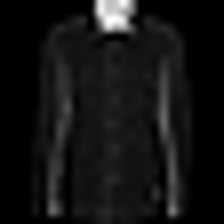

In [6]:
raw_dataset["train"][33]['image'].convert('RGB').resize((224,224))

In [7]:
im, l = raw_dataset["train"][33].values()
print(im)
print(l)

<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7BBC9E59D880>
6


### View sample images

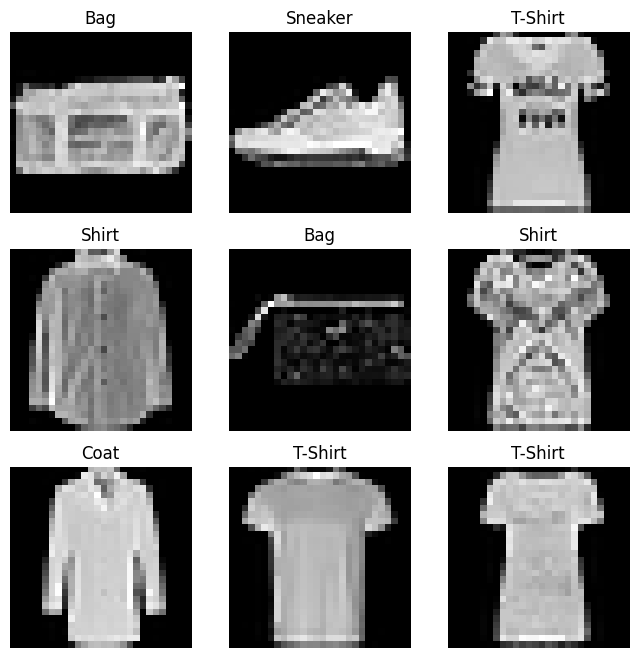

In [8]:
import torch
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3 # create a 3x3 plot of random image subplots
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(raw_dataset['train']), size=(1,)).item()
    img, label = raw_dataset['train'][sample_idx].values()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label]) #add the label as title to current subplot
    plt.axis("off")
    plt.imshow(img, cmap="gray") # we keep this as CMAP as they are single color images.
plt.show()

## Image Preprocessing
We need to modify the input images so they are compatible with our model. We will use [ViT](https://huggingface.co/google/vit-base-patch16-224). Vision Transformer (ViT) is an incredibly popular model/checkpoint that was trained on millions of images for image classification tasks. Training was on **colored images at resolution 224x224**. So our images will need to match this input.



In [9]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224"
feature_extractor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


the image processor is in charge of preparing input features for audio or vision models. Specifically in our case this will convert the images to 224x224 based on the requirements from ViT



In [10]:
def preprocess_images(examples):
    images = [x.convert('RGB') for x in examples['image']]
    inputs = feature_extractor(images=images, return_tensors="pt")
    examples['pixel_values'] = inputs['pixel_values']
    return examples

We don't really need to return the inputs above, but I find it helpful to look at what feature extracter is doing.

In [11]:
x = preprocess_images(raw_dataset['train'][0:2])
print(x.keys())
x['pixel_values'].shape


dict_keys(['image', 'label', 'pixel_values'])


torch.Size([2, 3, 224, 224])

Lets think about the shape above for a minute.
1.   We passed in 2 images hence the first dimension is 2
2.   We have 3 channels now (RGB), hence the next dimension is 3
3. Finally the feature extractor resized us up to 224x224

Also note we have a new column called pixel_values now.



The preprocess_image function brings things together. It does the actual conversion of the batches images to RGB. We also apply the feature extractor to apply the models inputs

## Development Setup
For development only lets do this with a smaller set of data or else it takes too long, for the final run this will be commented out

In [12]:
from datasets import DatasetDict, Dataset


train_dataset = Dataset.from_dict(raw_dataset["train"][:6000])
test_dataset = Dataset.from_dict(raw_dataset['test'][:1000])
dev_dataset = DatasetDict({
  'train': train_dataset,
  'test': test_dataset
})

dev_dataset
raw_dataset = dev_dataset ## Comment out this line if you want to run the full set

In [13]:

processed_datasets = raw_dataset.map(preprocess_images, batched=True)

#Remove unnecessary column
processed_datasets = processed_datasets.remove_columns(['image'])

# Rename columns to standard names as necessary (HF prefers labels)
processed_datasets = processed_datasets.rename_column("label", "labels")

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## Dataloaders
A Pytorch Dataloader makes it easy to iterate over batches of our data. We need to make sure HF returns tensors instead of datadicts as that what pytorch uses.

In [14]:
processed_datasets.set_format(type="torch", columns=['pixel_values', 'labels'])
training_data = processed_datasets["train"]
test_data = processed_datasets["test"]

In [15]:
from torch.utils.data import DataLoader

batch_size = 16 # this should be set to whatever your GPU can handle.

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)



Lets take a peek at the data. You can see below that our feature batch size is 64 (batch_size) * 3 * 224 * 224 which is exactly what we expect.

In [16]:
batch = next(iter(train_dataloader))

# Access the tensors using the correct dictionary keys
train_features = batch['pixel_values'] # <-- This is our batched image tensor
train_labels = batch['labels']         # <-- This is our batched label tensor

print(f"Feature batch shape: {train_features.size()}")
print(f"Label batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 3, 224, 224])
Label batch shape: torch.Size([16])


Once again, we can display the image. Note we are just using img[0] which I'm guessing represents 'R' for Red. This is not accurate, in the real world you would do a weighted average or a mean of the 3 values. But since all we are doing is displaying it does not really make a difference.

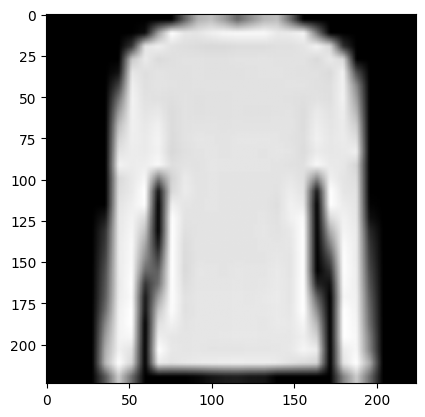

Label: Pullover


In [17]:
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {labels_map[label.item()]}")


## Setup the model
Ok our data is all ready to go, now its training time! As before we will use the ViT model. This is trained on 1000 labels, we only have 10. Hence we provide a num_labels and ignore_mismatched_sizes as arguments below. What this effectively does is drop the "head" of the NN and replaces it with our 10 labels. This is why HuggingFace gives us a warning reminding us to train the model and not use it directly.

In [18]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(checkpoint, num_labels=len(labels_map), ignore_mismatched_sizes=True)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next, lets load the batch into the model to make sure it retuns an output. And it does. As expected the returned value is a 64 (batch) * 10 (labels) tensor.

In [19]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(2.4714, grad_fn=<NllLossBackward0>) torch.Size([16, 10])


For our optimizer, lets pick AdamW which is a popular choice. This decides the magnitude and direction for updating parameters

In [20]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

Now we setup a learning rate scheduler. This decreases the learning rate during the course of training. A dynamic LR trans more effectively and mitigates the need to experiment to pick a static rate

In [21]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader) # number of batches
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer, # Link your optimizer from above here
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1125


A quick note, the length of our train_dataloader represents the number of batches. We have 6000 rows of data and a batch size of 16. 6000/16 = 375 which matches the number below.

In [22]:
len(train_dataloader)

375

## Train
Finally we can go ahead and train, first we use a standard pytorch snippet to set a device type incase we have a NVIDIA GPU.

In [23]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

Finally we run our Gradient Desent to train the model.

In [24]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:

        # Move Data to GPU 🚀
        # the v.to copies/duplicates the tensor to the GPU if it exists
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward Pass (Prediction)
        # Pass the batch of data through the model to get predictions and calculate the loss.
        outputs = model(**batch)
        loss = outputs.loss

        # Backward Pass (Gradient Calculation)
        # Compute the gradients (slopes) of the loss with respect to every single parameter (weight/bias)
        # in the model. This is the core of backpropagation.
        loss.backward()

        # Update the model's weights and biases using the calculated gradients,
        optimizer.step()

        # Update the learning rate based on the scheduler's strategy aka decreasing it before the next step

        lr_scheduler.step()


        # Reset the gradients of all parameters to zero.
        optimizer.zero_grad()

        progress_bar.update(1)

  0%|          | 0/1125 [00:00<?, ?it/s]

## Validate

In [25]:
model.to(device)
model.eval() # Turns off training


all_predictions = []
all_references = [] # Store the true labels

with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs to the device (GPU)
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Get the predicted class indices
        # outputs.logits contains the raw prediction scores for each class
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Store predictions and true labels (references)
        # Move tensors back to CPU and convert to a Python list/NumPy array
        all_predictions.extend(predictions.cpu().tolist())
        all_references.extend(batch['labels'].cpu().tolist())



In [31]:
import evaluate

# 1. Combine the metrics into a single object
clf_metrics = evaluate.combine(["f1", "precision", "recall"])

# We continue to use average="macro" for the metrics that require it (f1, precision, recall).
results = clf_metrics.compute(
    predictions=all_predictions,
    references=all_references,
    average="macro"  # Applies the macro-average to F1, Precision, and Recall
)

print(f"F1 Score:  {results['f1']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall:    {results['recall']:.4f}")

F1 Score:  0.9336
Precision: 0.9343
Recall:    0.9335


## Analysis
Our model, which was just trained on 6k out of 60k samples is performing exceedingly well.
| Metric | Score | Notes |
| :--- | :---: | ---: |
| Precision | 0.9343 | This is the accuracy of positive predictions, or how we handle false positives. Or it doesnt label incorrectly often |
| Recall | 0.9335 | This represents the completeness of our predictions. AKA we got 93% of the images matching a class (we rarely miss an image) |
| F1 | 0.9335 | F1 is the harmonic mean (balance) of precision and recall. This means we maintain a strong balance between the first 2 metrics |


### What the High Scores (0.93+) Signify*
An averaged score of over $0.93$ indicates outstanding performance.


1.   Since the scores are so high and close together, our model has learned very distinct features is generalizing extremely well to the unseen test data.
2.   FP & FN are very low as one would expect in a high performing model.
3.   The match between Precision and Recall suggests our model is well-balanced. It isn't overly aggressive (high FP) or overly cautious (high FN).

In [28]:
accuracy = evaluate.load("accuracy")
accuracy.compute(predictions=all_predictions, references=all_references)

{'accuracy': 0.932}